# Reconocedor de puntos clave faciales con Python
## Ejemplo de implementación utilizando OpenCV y Redes Neuronales Convolucionales

Aquí puedes encontrar la presentación en la que se basa esta implementación.

Para hacerlo más fácil, se ha separado en diferentes pasos diferenciados por funcionalidad. Las partes son:

[**Paso 1**](#step0) : Detectar las caras a partir de modelos definidos en OpenCV.

[**Paso 2**](#step1) : Definición y entrenamiento de una Red Neuronal Convolucional (CNN) en Keras.

[**Paso 3**](#step1) : Aplicar el conocimiento de la CNN a cada una de las caras detectadas en las imágenes en el [**Paso 1**](#step0).

In [1]:
# Import required libraries for this section

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time

from keras.models import load_model


# Auxiliary functions

def read_image(path):
    """ Method to read an image from file to matrix """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_image(image, title=''):
    """ It plots an image as it is in a single column plot """
    # Plot our image using subplots to specify a size and title
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_title(title)
    ax1.imshow(image)



Using TensorFlow backend.


<a id='step0'></a>
# Paso 1: Detectar las caras a partir de modelos definidos en OpenCV

Definición de los métodos que utilizaremos.

get_faces: A partir de una imagen se devuelve el conjunto de caras detectadas

plot_faces: Muestra las caras detectadas sobre la imagen original




In [2]:
def get_faces(image):
    """
    It returns an array with the detected faces in an image
    Every face is defined as OpenCV does: top-left x, top-left y, width and height.
    """
    # To avoid overwriting
    image_copy = np.copy(image)
    
    # The filter works with grayscale images
    gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_classifier = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')
    
    # Detect the faces in image
    faces = face_classifier.detectMultiScale(gray, 1.2, 5)
    
    return faces 

def draw_faces(image, faces=None, plot=True):
    """
    It plots an image with its detected faces. If faces is None, it calculates the faces too
    """
    if faces is None:
        faces = get_faces(image)
    
    # To avoid overwriting
    image_with_faces = np.copy(image)
    
    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # Add a red bounding box to the detections image
        cv2.rectangle(image_with_faces, (x,y), (x+w,y+h), (255,0,0), 3)
        
    if plot is True:
        plot_image(image_with_faces)
    else:
        return image_with_faces
    
    

def plot_image_with_keypoints(image, image_info):
    """
    It plots keypoints given in (x,y) format
    """
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    
    for (face, keypoints) in image_info:
        for (x,y) in keypoints:
            ax1.scatter(x, y, marker='o', c='c', s=10)
   

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(image)

    
    
    

Faces detected: 9


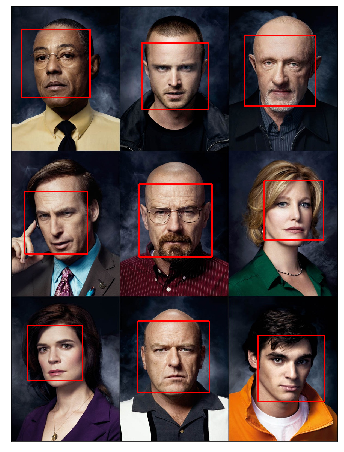

In [3]:
image = read_image('images/breaking_bad.jpg')
faces = get_faces(image)
print("Faces detected: {}".format(len(faces)))
draw_faces(image, faces)

<a id='step1'></a>
# Paso 2:  Definición y entrenamiento de una Red Neuronal Convolucional (CNN) en Keras

En este paso se define una red neuronal convolucional para sacar los keypoints de cada una de las fotos detectadas. La implementación se realizará en Keras, usando Tensorflow como backend.

Para poder hacer uso del conocimiento de la red neuronal hay que entrenarla con datos previos. En kaggle podemos encontrar [este dataset](https://www.kaggle.com/c/facial-keypoints-detection/data) que contiene 60MB  de imágenes, cada una con un tag en los keypoints.

Estos keypoints serán 15: 4 en la boca, 1 en la nariz, 3 en cada ojo y 2 en cada ceja.

Lo primero que haremos será cargar estas imágenes y prepararlas para el entrenamiento


In [4]:
from utils import *

# Load training set
# load_data es un método definido en el fichero utils para cargar las imágenes.
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


## Visualización de los datos de entrenamiento

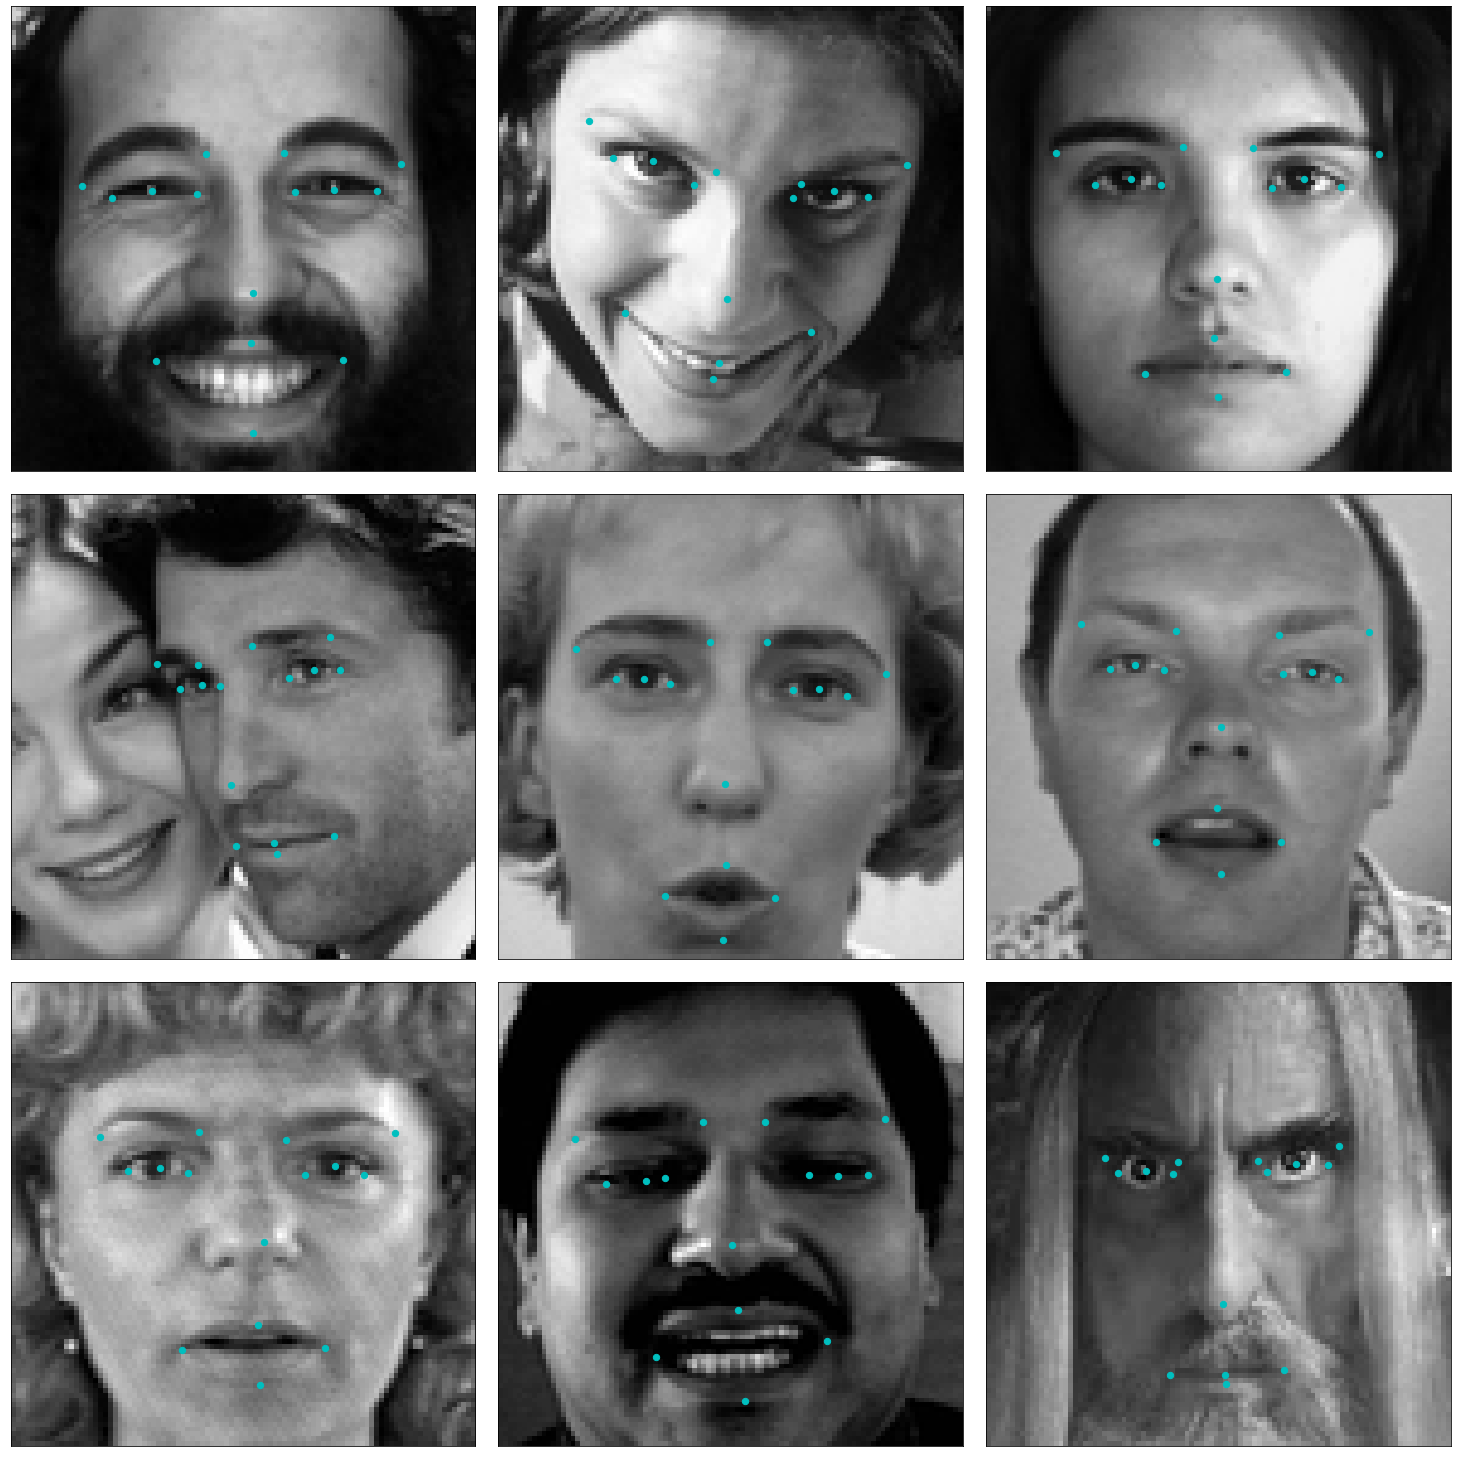

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

## Definición de la Red Neuronal Convolucional

La red neuronal definida tiene una complejidad básica-media. No es el objetivo entenderla al 100%. Puede ser interesante ver cómo se alternan capas convolucionales que dan profundidad a la red con capas de "pooling", que reducen el tamaño de las imágenes.

También se puede ver cómo se han añadido capas de Dropout (descarte de un porcentaje de los resultados intermedios) para evitar el overfitting.

Al final se termina con una capa densa de 30 valores, un valor por cada posición "x" e "y" de los 15 keypoints

In [6]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense


# Your model should accept 96x96 pixel graysale images in
# It should have a fully-connected output layer with 30 values (2 for each facial keypoint)
shape = (96,96)
model = Sequential()
model.add(Convolution2D(16,(2,2),padding='same',input_shape=(96,96, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=3))

model.add(Convolution2D(32,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Convolution2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Convolution2D(128,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(30))


# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)         

## Compilación y entrenamiento de la Red Neuronal Convolucional

Para compilar y entrenar una red neuronal hay un millón de combinaciones posibles dependiendo de la configuración de lo que se denominan "hiperparámetros".

Tampoco es objeto de estudio la optimización de una red neuronal, por lo que se han realizado diferentes pruebas y los mejores resultados obtenidos han sido los siguientes (¡te animamos a que pruebes los tuyos!):

 optimizer: adam

loss: mse

batch_size: 20

validation:split: 0.2

In [7]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import ModelCheckpoint, History  

epochs = 50
histo = History()

## Compile the model
def compile_model(model, epochs):
    
    filepath = 'model.hdf5'
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath=filepath, 
                                   verbose=1, save_best_only=True)

    ## Train the model
    hist = model.fit(X_train, y_train, validation_split=0.2,
              epochs=epochs, batch_size=20, callbacks=[checkpointer, histo], verbose=1)
    
    model.save(filepath)
    
    return hist

def show_training_validation_loss(hist, epochs):
    plt.plot(range(epochs), hist.history[
             'val_loss'], 'g-', label='Val Loss')
    plt.plot(range(epochs), hist.history[
             'loss'], 'g--', label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

# TODO: Set True if you want to train the network. It will get a pretrained network values from a file.
train_net = False

if train_net is True:
    hist = compile_model(model, epochs) 
else:
    model.load_weights('model.hdf5')




In [ ]:
# Visualize the training and validation loss of the neural network
if train_net is True:
    show_training_validation_loss(hist, epochs)

Sample of an almost ideal training process: 

<img src="images/adam.png" width=400 height=300/>

<a id='step2'></a>
# Paso 3:  Aplicar el conocimiento de la CNN a cada una de las caras detectadas

Vamos a elegir la misma imagen que al al principio, y vamos a representar en las caras los keypoints de cada uno.

La red neuronal se ha entrenado con imágenes de 96x96, por lo que habrá que escalar el rectángulo que delimita las caras a esa escala para poder extraer los keypoints

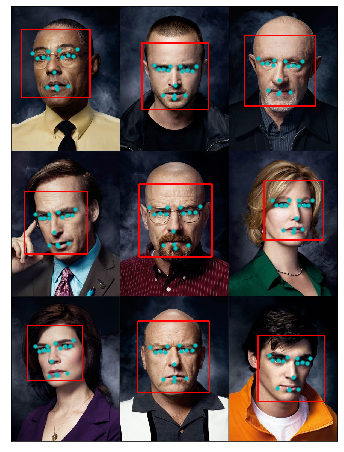

In [8]:
def get_keypoints(image, faces=None):
    
    # list of pairs (face, keypoints)
    result = []
    
    if faces is None:
        faces = get_faces(image)
    
    # Same size than training/validation set
    faces_shape = (96, 96)
    
    # To avoid overwriting
    image_copy = np.copy(image)
    
    # For each face, we detect keypoints and show features
    for (x,y,w,h) in faces:

        # We crop the face region
        face = image_copy[y:y+h,x:x+w]

        # Face converted to grayscale and resize (our CNN receives images of 96x96x1)
        gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        resize_gray_face = cv2.resize(gray_face, faces_shape) / 255

        # Formatting x inputs. Inputs will have format of (1, 96, 96, 1)
        inputs = np.expand_dims(np.expand_dims(resize_gray_face, axis=-1), axis=0)
                                
        # Get keypoints result                        
        predicted_keypoints = model.predict(inputs)

        # All keypoints in a single flat array. We will retrieve keypoints as (x,y) with (idx, idx+1) values.
        predicted_keypoints = np.squeeze(predicted_keypoints)
        
        keypoints = []        
        for idx in range(0, len(predicted_keypoints), 2):
            # Scale factor (revert scale)
            x_scale_factor = face.shape[0]/faces_shape[0] 
            y_scale_factor = face.shape[1]/faces_shape[1] 

            # Offset of the center of the scatter
            x_center_left_offset = predicted_keypoints[idx] * faces_shape[0]/2 + faces_shape[0]/2 
            y_center_left_offset = predicted_keypoints[idx + 1] * faces_shape[1]/2 + faces_shape[1]/2
            
            x_center = int(x + (x_scale_factor * x_center_left_offset))
            y_center = int(y + (y_scale_factor * y_center_left_offset))

            keypoints.append([x_center, y_center])
        
        result.append([(x,y,w,h), keypoints])
    
    return result

def show_image_and_features(image_path):
    image = read_image(image_path)
    faces = get_faces(image)
    keypoints = get_keypoints(image, faces)
    image_with_faces = draw_faces(image, faces ,plot=False)
    plot_image_with_keypoints(image_with_faces, keypoints)

show_image_and_features('images/breaking_bad.jpg')


Vamos a probar el algoritmo en una image mayor para observar las características más en detalle

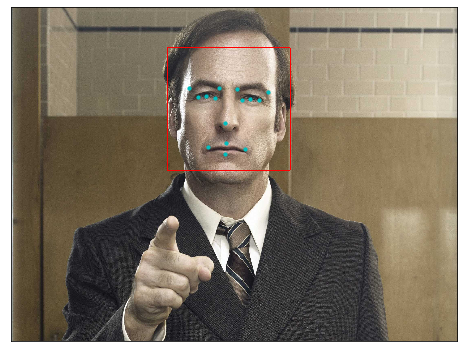

In [9]:
show_image_and_features('images/saul_goodman.jpg')

## Extra. ¿Nos atrevemos a ponerle una gafas a partir de los keypoints?

Lo primero que tenemos que saber qué índice contiene qué keypoint. En la documentacion del dataset de kaggle podemos encontrar:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Cuando hacemos referencia a izquierda o derecha es con respecto a la persona. En la imagen anterior, el ojo izquierdo es el que tiene un valor de x mayor.

Después lo adaptamos a nuestra imagen.

<img src="images/thug_life_with_range.png" width=400 height=300/>

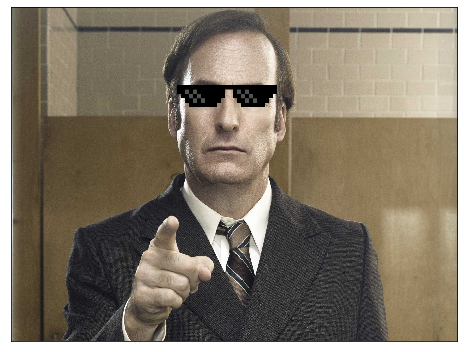

In [10]:
# Below we show the (guessed) bounding rectangle for the eyes underneath the sunglasses
# We'll use the bounding rectangle to figure out how to map the glasses on the eye keypoints
# Values were obtained via experimentation
# glasses_triangle_vertices = np.array([(280,220), (2800,220), (280,600)]).astype(np.float32)
thug_glasses_triangle_vertices = np.array([(65,10), (490,10), (65,70)]).astype(np.float32)



def thug_image(image):
    faces = get_faces(image)
    image_info = get_keypoints(image, faces)
    
    # Load in sunglasses image - note the usage of the special option
    # cv2.IMREAD_UNCHANGED, this option is used because the sunglasses 
    # image has a 4th channel that allows us to control how transparent each pixel in the image is
    sunglasses = cv2.imread("images/thug_life.png", cv2.IMREAD_UNCHANGED)    
    alpha_channel = sunglasses[:,:,3]
    
    for (face, keypoints) in image_info:
    
        # We keep only the keypoints related to eyes (from 0 to 9)
        eye_keypoints = keypoints[:10]

        # Compute the bounding rectangle for the eyes
        eye_boundingRect = cv2.boundingRect(np.array(eye_keypoints).astype(np.float32))
        # Build the triangle vertices needed by cv2.getAffineTransform()
        eyes_triangle_vertices = np.array([(eye_boundingRect[0],eye_boundingRect[1]), 
                                           (eye_boundingRect[0]+eye_boundingRect[2],eye_boundingRect[1]), 
                                           (eye_boundingRect[0],eye_boundingRect[1]+eye_boundingRect[3])]).astype(np.float32)
        # Compute the affine transform matrix from the two sets of three points (glasses and eyes)
        map_matrix = cv2.getAffineTransform(thug_glasses_triangle_vertices, eyes_triangle_vertices)
        # Apply the affine transformation to the glasses
        transformed_sunglasses = cv2.warpAffine(sunglasses, map_matrix, (image.shape[1], image.shape[0]))
        # Build a binary mask of the pixels where the sunglasses are
        transformed_sunglasses_mask = transformed_sunglasses[:,:,3] > 0
        # Overwrite pixels in the original image with sunglasses pixels using their mask
        image[:,:,:][transformed_sunglasses_mask] = transformed_sunglasses[:,:,0:3][transformed_sunglasses_mask]
    
    return image   

thug_life_image = thug_image(read_image('images/saul_goodman.jpg'))
plot_image(thug_life_image)
    

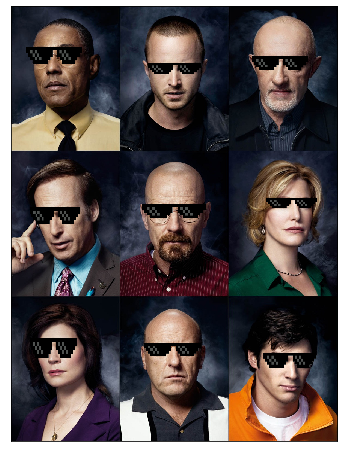

In [11]:
thug_life_image = thug_image(read_image('images/breaking_bad.jpg'))
plot_image(thug_life_image)

## Extra 2. Aplica el filtro con la web cam!

In [1]:
import cv2
import time 
from keras.models import load_model
def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # keep video stream open
    while rval:
        # plot image from camera with detections marked
        frame = thug_image(frame)
        cv2.imshow("face detection activated", frame)
        
        # exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # exit by pressing any key
            # destroy windows
            cv2.destroyAllWindows()
            
            # hack from stack overflow for making sure window closes on osx --> https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read() 

Using TensorFlow backend.


In [2]:
# Run your keypoint face painter
laptop_camera_go()

NameError: name 'thug_image' is not defined